In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from helpers import *
from implementations import *

def get_label(data_path):
    lbl = []
    with open(data_path, 'r') as f:
        lbl = f.readline().rstrip().split(',')
    
    # first 107 features
    #lbl = lbl[1:108]
    lbl = lbl[1:]
    l_dict = {}
    for i, l in enumerate(lbl):
        l_dict.update({l: i})
    return lbl, l_dict

In [3]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data('data/dataset')

y = y_train
print(x_train.shape)

(328135, 321)


Explore the first 107 features

In [4]:
#x = x_train[:,:107]
x = x_train[:,:]
print(x_train[:,9])
x[np.isnan(x)] = -1
print(x[:,9])

[nan  1.  1. ...  1.  1.  1.]
[-1.  1.  1. ...  1.  1.  1.]


In [5]:
lbl, l_dict = get_label('data/dataset/x_train.csv')

It can be seen that there are two catagories of data by columns like 'CTELENUM / CTELNUM1' and 'PVTRESD1 / PVTRESD2', so we want to split the dataset into two set such that we may train different models later.

In [6]:
def split_data(x):

    indexes1 = np.where(x[:, l_dict['CTELNUM1']] == -1)
    i1p = np.where(x[:, l_dict['PVTRESD2']] == -1)
    indexes2 = np.where(x[:, l_dict['CTELENUM']] == -1)
    i2p = np.where(x[:, l_dict['PVTRESD1']] == -1)
    result1 = np.setdiff1d(i1p, indexes1)
    result2 = np.setdiff1d(i2p, indexes2)
    print(result1, result2)
    x_splits = [x[indexes1], x[indexes2]]
    y_splits = [y[indexes1], y[indexes2]]
    return x_splits, y_splits

def remove_irrelevant_col(x):
    relevant_indexes = []
    for i, col in enumerate(x.T):
        # define the irrelevant columns: 90% of values are 1/-1
        if np.mean(col == 1) >= 0.9 or np.mean(col == -1) >= 0.9:
            continue
        relevant_indexes.append(i)
    return x[:, relevant_indexes], relevant_indexes

In [7]:
x_splits, y_splits = split_data(x)
x_zero, relevant_indexes_zero = remove_irrelevant_col(x_splits[0])
x_one, relevant_indexes_one = remove_irrelevant_col(x_splits[1])
x_splits = [x_zero, x_one]
ridx_splits = [relevant_indexes_zero, relevant_indexes_one]
rlbl_splits = [[lbl[i] for i in relevant_indexes_zero], [lbl[i] for i in relevant_indexes_one]]

[] []


By the scatter plot above It can be seen that most of the features are distributed uniformly, which suggests that they maybe not correlated to the prediction. However, there are some features like 'DRNK3GE5' and 'MAXDRNKS' that maybe important.

Now we want to clean the data. Note that for both catagories, we have already remove those features with alomost all 1 or -1(nan). Now we want to do it more carefully by dealing with all nan and extreme data.
First, we want to see the box plot of the relevant features

In [8]:
rl_dict = [{}, {}]
for i, l in enumerate(rlbl_splits[0]):
    rl_dict[0].update({l:i})
for i, l in enumerate(rlbl_splits[1]):
    rl_dict[1].update({l:i})

print(rl_dict[0]["IMFVPLAC"])
print(np.mean(x_splits[0][:,85] == -1))

85
0.5168662568885121


From the box plot, we find that most of the features has nan points, and we want to replace these points with the median/average. However, there are cases that nan points occupy 50% of the points (like IMFVPLAC"). Thus we need to discuss how to deal with them. There are two methods to be test: replace the nan (-1) by median (or average). To be thought: do we need to deal with extreme value (now do nothing)? What is the threshold to define relevant features (now 90%).

In [9]:
def clean_data(x):
    x_clean = x.copy()
    for i, col in enumerate(x_clean.T):
        mean_value = np.mean(col[col != -1])
        #col[(col > 10 * mean_value) | (col == -1)] = mean_value
        col[col == -1] = mean_value
    return x_clean

In [10]:
x_clean_0 = clean_data(x_splits[0])
x_clean_1 = clean_data(x_splits[1])
x_clean = [x_clean_0, x_clean_1]
print(not np.any(x_clean_1 == -1)) # no -1 in cleaned x
#plot_box(x_clean_1, rlbl_splits[1])

True


Now we want to check the correlation among the cleaned features and the prediction y:

In [11]:
from model import *
print(y_splits[0].shape, x_clean[0].shape)
#demo(y_splits[0], x_clean[0], 1000, 5, [1], np.logspace(-3, 0, 4))

(188720,) (188720, 202)


In [38]:
from model import *

In [13]:
def normalize_features(x):
    """
    Normalize the features using Z-score normalization.
    """
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    standardized_x = (x - mean) / std
    return standardized_x

In [14]:
x_train=normalize_features(x_clean[0])
print(x_train.shape)

(188720, 202)


reg_logistic  extension degree 1, Lambda value 1.000000, train_loss = 0.486317, test_loss = 0.486568, train_f1 = 0.326281, test_f1 = 0.325260
reg_logistic  extension degree 1, Lambda value 3.000000, train_loss = 0.603012, test_loss = 0.603134, train_f1 = 0.372570, test_f1 = 0.370783
reg_logistic  extension degree 1, Lambda value 5.000000, train_loss = 0.635374, test_loss = 0.635455, train_f1 = 0.377924, test_f1 = 0.377348
reg_logistic  extension degree 1, Lambda value 7.000000, train_loss = 0.650589, test_loss = 0.650649, train_f1 = 0.378484, test_f1 = 0.378450


<Figure size 640x480 with 0 Axes>

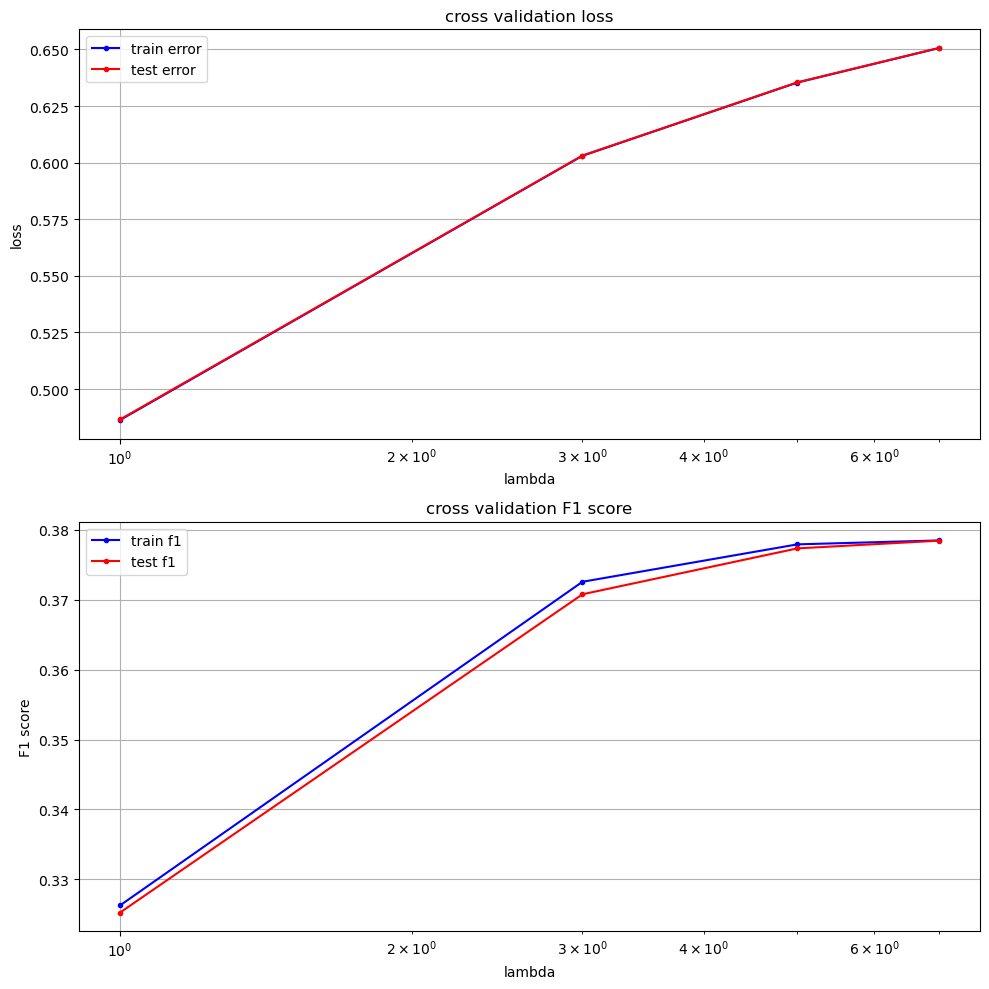

In [57]:
demo(y_splits[0], x_train, 1000, 5, [1], [1,3,5,7])

In [58]:
def smote_oversampling(x_train, y_train, minority_class, k_neighbors, oversampling_ratio):
   
    minority_indices = np.where(y_train == minority_class)[0]
       
    num_synthetic_samples = int(len(minority_indices) * oversampling_ratio)
    
    synthetic_samples = []
    
    for _ in range(num_synthetic_samples):
       
        random_minority_index = np.random.choice(minority_indices)
        minority_sample = x_train[random_minority_index]
        
  
        distances = np.linalg.norm(x_train - minority_sample, axis=1)
        sorted_indices = np.argsort(distances)
        nearest_neighbors_indices = sorted_indices[1:k_neighbors+1]  
        
   
        random_neighbor_index = np.random.choice(nearest_neighbors_indices)
        neighbor_sample = x_train[random_neighbor_index]
        
        synthetic_sample = minority_sample + np.random.random() * (neighbor_sample - minority_sample)
        
        synthetic_samples.append(synthetic_sample)
    
  
    x_train_oversampled = np.vstack([x_train, np.array(synthetic_samples)])
    y_train_oversampled = np.hstack([y_train, np.full(num_synthetic_samples, minority_class)])
    
    return x_train_oversampled, y_train_oversampled



In [59]:
x_train_oversampled, y_train_oversampled = smote_oversampling(x_train, y_splits[0], minority_class=1, k_neighbors=5, oversampling_ratio=)

In [62]:
y_train_oversampled.shape

(198862,)

reg_logistic  extension degree 1, Lambda value 7.000000, train_loss = 0.654894, test_loss = 0.654946, train_f1 = 0.432225, test_f1 = 0.430788


<Figure size 640x480 with 0 Axes>

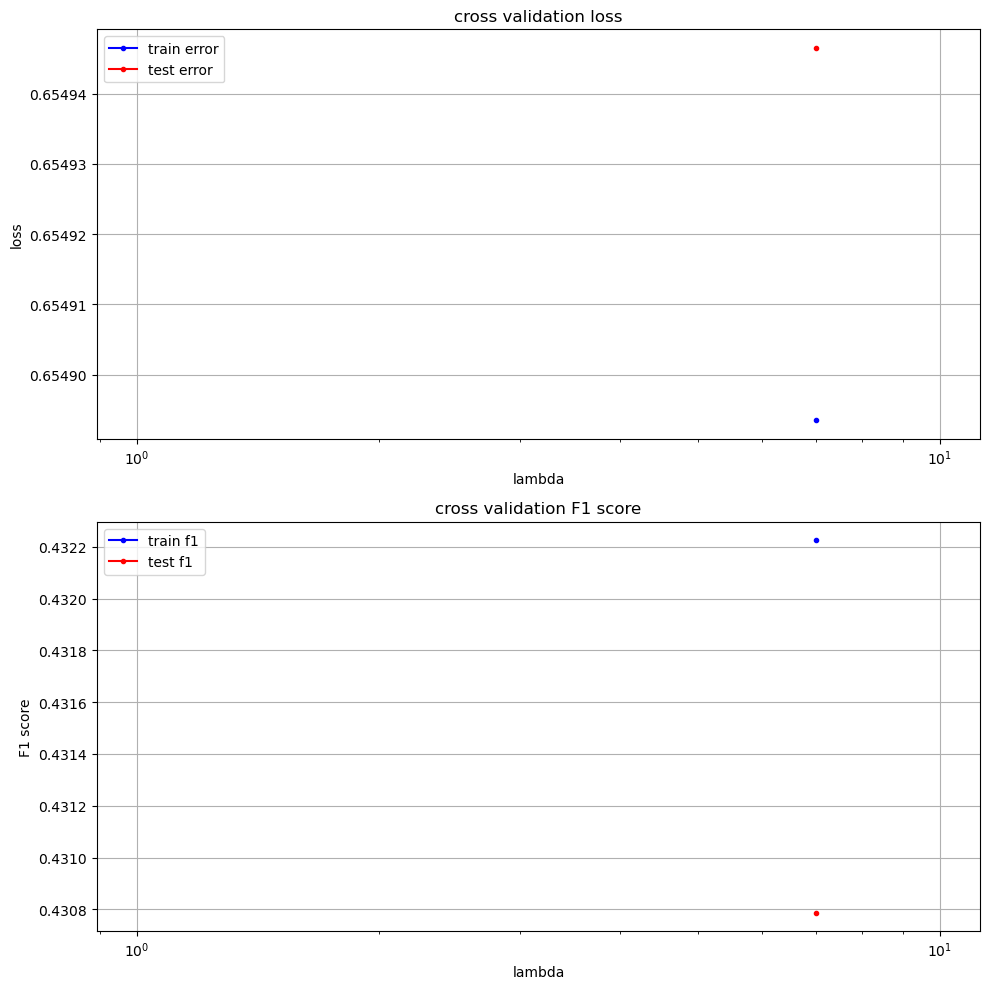

In [63]:
demo(y_train_oversampled, x_train_oversampled, 1000, 5, [1], [7])